In [176]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ibmqfactory.load_account:WARNING:2022-04-09 02:52:56,415: Credentials are already in use. The existing account in the session will be replaced.


In [177]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'C:\\Users\\asus\\AppData\\Roaming\\Python\\Python38\\site-packages\\qiskit\\utils\\mitigation\\fitters.py'

In [178]:
n_steps=100
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                0,                0,                0,                0,                0,                0,   0],
[  0, 1.0 + 0.000459*I,       0.000459*I,                0,      -0.000918*I,                0,                0,   0],
[  0,       0.000459*I, 1.0 - 0.000918*I,                0,       0.000459*I,                0,                0,   0],
[  0,                0,                0, 1.0 + 0.000459*I,                0,       0.000459*I,      -0.000918*I,   0],
[  0,      -0.000918*I,       0.000459*I,                0, 1.0 + 0.000459*I,                0,                0,   0],
[  0,                0,                0,       0.000459*I,                0, 1.0 - 0.000918*I,       0.000459*I,   0],
[  0,                0,                0,      -0.000918*I,                0,       0.000459*I, 1.0 + 0.000459*I,   0],
[  0,                0,                0,                0,                0,                0,                0, 1.0]])

In [179]:
B = Matrix([
    [0,0,0,0,1,0,0,0],
    [0,0,1,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,1]
])
B

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 1]])

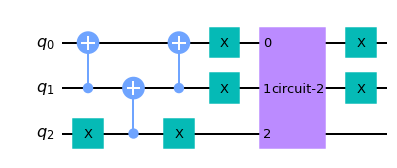

In [180]:
qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.append(Toffoli_gate,[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

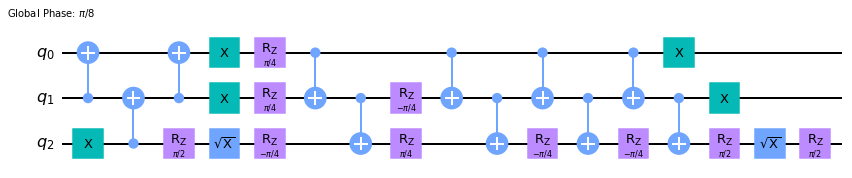

In [181]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

In [182]:
n_steps = 42
time = np.pi
precision = 40

numeric_evolution_matrix=eye(8)

#for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
#
#    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix_(2*time/n_steps)).evalf(precision)


M_N = B*trotterized*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[       1.0 + 0.0004591*I, -2.8546e-5 + 0.0004591*I,   2.918e-5 - 0.0009182*I,                  0],
[  2.918e-5 + 0.0004591*I,        1.0 - 0.0009182*I, -2.8546e-5 + 0.0004591*I,                  0],
[-2.8546e-5 - 0.0009182*I,   2.918e-5 + 0.0004591*I,        1.0 + 0.0004591*I,                  0],
[                       0,                        0,                        0, 1.0 + 2.2204e-15*I]])

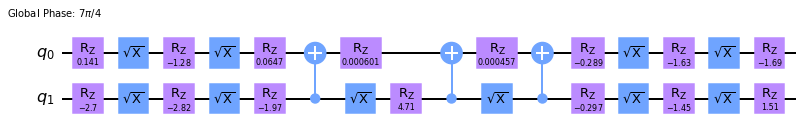

In [183]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

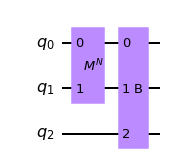

In [184]:
initial_state="000"

qr_U = QuantumRegister(3, name="q")
qc_U = QuantumCircuit(qr, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc.x(qr[k])
    l+=1

### appending the evolution

qc_U.append(M_N_qc,[qr[0],qr[1]])
qc_U.append(B_qc,[qr[0],qr[1],qr[2]])

qc_U.draw(output="mpl")

In [185]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[                            0,                             0,                             0,   0, 0.9999993668 + 0.0004591001*I,  -2.85464e-5 + 0.0004591001*I,   2.91796e-5 - 0.0009182003*I,   0],
[ -2.85464e-5 - 0.0009182003*I,   2.91796e-5 + 0.0004591001*I, 0.9999993668 + 0.0004591001*I,   0,                             0,                             0,                             0,   0],
[  2.91796e-5 + 0.0004591001*I, 0.9999993668 - 0.0009182003*I,  -2.85464e-5 + 0.0004591001*I,   0,                             0,                             0,                             0,   0],
[0.9999993668 + 0.0004591001*I,  -2.85464e-5 + 0.0004591001*I,   2.91796e-5 - 0.0009182003*I,   0,                             0,                             0,                             0,   0],
[                            0,                             0,                             0, 1.0,                             0,                             0,                             0,   0],
[

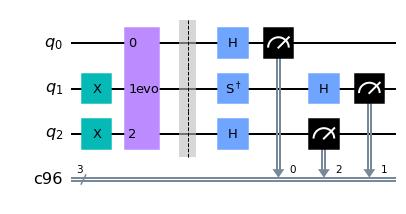

In [186]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [187]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [188]:
cal_circ[0].draw()

░ ┌─┐      
q6582_0: ─░─┤M├──────
          ░ └╥┘┌─┐   
q6582_1: ─░──╫─┤M├───
          ░  ║ └╥┘┌─┐
q6582_2: ─░──╫──╫─┤M├
          ░  ║  ║ └╥┘
  c97: 3/════╩══╩══╩═
             0  1  2

In [189]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [190]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.x(qr_cal_id)
    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
        else:
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [191]:
calib_circuits_identity[1].draw()

┌───┐┌──────┐     ┌─┐      
q6586_0: ┤ X ├┤0     ├─────┤M├──────
         ├───┤│      │┌───┐└╥┘┌─┐   
q6586_1: ┤ X ├┤1 evo ├┤ X ├─╫─┤M├───
         ├───┤│      │├───┤ ║ └╥┘┌─┐
q6586_2: ┤ X ├┤2     ├┤ X ├─╫──╫─┤M├
         └───┘└──────┘└───┘ ║  ║ └╥┘
 c101: 3/═══════════════════╩══╩══╩═
                            0  1  2

In [192]:
calib_circuits_itself[1].draw()

┌───┐┌──────┐┌─┐      
q6585_0: ┤ X ├┤0     ├┤M├──────
         └───┘│      │└╥┘┌─┐   
q6585_1: ─────┤1 evo ├─╫─┤M├───
              │      │ ║ └╥┘┌─┐
q6585_2: ─────┤2     ├─╫──╫─┤M├
              └──────┘ ║  ║ └╥┘
 c100: 3/══════════════╩══╩══╩═
                       0  1  2

In [193]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [194]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [195]:
Matrix(meas_fitter_qiskit.cal_matrix)

Matrix([
[  0.951125, 0.04790625, 0.03446875,    0.00175,   0.042875,    0.00225,   0.001375,   3.125e-5],
[ 0.0164375, 0.91940625,  0.0004375, 0.03371875,   0.000625,  0.0384375,   0.000125, 0.00115625],
[0.00821875, 0.00040625,  0.9244375,    0.04975, 0.00028125,          0, 0.03953125,  0.0016875],
[  0.000125,   0.006625, 0.01528125, 0.88934375,          0,  0.0004375, 0.00071875, 0.03815625],
[ 0.0234375,  0.0011875,      0.001,    6.25e-5,  0.9314375,  0.0480625,      0.035, 0.00178125],
[ 0.0004375, 0.02415625,          0, 0.00109375, 0.01734375,    0.90325,     0.0005,  0.0340625],
[0.00021875,          0,  0.0239375, 0.00109375,  0.0073125, 0.00028125, 0.90728125,    0.04375],
[         0,  0.0003125,  0.0004375,  0.0231875,   0.000125, 0.00728125, 0.01546875,   0.879375]])

In [196]:
Matrix(meas_fitter_our_identity.cal_matrix)

Matrix([
[  0.894375, 0.06359375, 0.05259375,   0.004375,  0.0503125, 0.00440625,   0.005375, 0.01303125],
[0.03090625, 0.86165625, 0.00246875, 0.04753125, 0.00209375,   0.047125,   0.013625,   0.003625],
[ 0.0256875,      0.002, 0.86665625, 0.06209375, 0.00328125, 0.01353125, 0.04734375,   0.003125],
[0.00146875,    0.02525,  0.0290625, 0.83759375, 0.01271875, 0.00315625,  0.0018125, 0.04571875],
[0.03115625,   0.002625, 0.00353125, 0.01203125,  0.8756875,  0.0601875,   0.050375, 0.00396875],
[0.00178125, 0.03053125,  0.0130625, 0.00315625, 0.03040625,  0.8456875, 0.00234375, 0.04896875],
[   0.00275, 0.01209375, 0.03134375,   0.002125, 0.02453125,    0.00175, 0.84990625,   0.060875],
[  0.011875,    0.00225, 0.00128125, 0.03109375, 0.00096875, 0.02415625, 0.02921875,  0.8206875]])

In [197]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [198]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [199]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q7886_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q7886_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q7886_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
 c114: 3/══════╩════════════════╩══╩═
               1                0  2

In [200]:
meas_fitter_qiskit.cal_matrix

array([[9.5112500e-01, 4.7906250e-02, 3.4468750e-02, 1.7500000e-03,
        4.2875000e-02, 2.2500000e-03, 1.3750000e-03, 3.1250000e-05],
       [1.6437500e-02, 9.1940625e-01, 4.3750000e-04, 3.3718750e-02,
        6.2500000e-04, 3.8437500e-02, 1.2500000e-04, 1.1562500e-03],
       [8.2187500e-03, 4.0625000e-04, 9.2443750e-01, 4.9750000e-02,
        2.8125000e-04, 0.0000000e+00, 3.9531250e-02, 1.6875000e-03],
       [1.2500000e-04, 6.6250000e-03, 1.5281250e-02, 8.8934375e-01,
        0.0000000e+00, 4.3750000e-04, 7.1875000e-04, 3.8156250e-02],
       [2.3437500e-02, 1.1875000e-03, 1.0000000e-03, 6.2500000e-05,
        9.3143750e-01, 4.8062500e-02, 3.5000000e-02, 1.7812500e-03],
       [4.3750000e-04, 2.4156250e-02, 0.0000000e+00, 1.0937500e-03,
        1.7343750e-02, 9.0325000e-01, 5.0000000e-04, 3.4062500e-02],
       [2.1875000e-04, 0.0000000e+00, 2.3937500e-02, 1.0937500e-03,
        7.3125000e-03, 2.8125000e-04, 9.0728125e-01, 4.3750000e-02],
       [0.0000000e+00, 3.1250000e-04, 4.3

In [201]:
C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [202]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [203]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [204]:
raw_res.get_counts(-1)

{'110': 26736,
 '111': 1019,
 '010': 1491,
 '000': 779,
 '100': 1185,
 '101': 619,
 '001': 61,
 '011': 110}

In [205]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [206]:
itself_res.get_counts(-1)

{'000': 6.622862643094725e-11,
 '010': 3.1960742061739353e-12,
 '100': 1.1676462480013346e-10,
 '110': 31999.999999999898,
 '111': 3.659524212423781e-11}

In [207]:
identity_res.get_counts(-1)

{'000': 446.42445525935256,
 '001': 3.747137670586975e-08,
 '100': 4.2374975978029374e-08,
 '101': 357.4283049810683,
 '110': 31196.147239698406}

In [208]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.83359792, 0.91835448, 0.9948397 , 0.99463925])